# Práctica 6: Esqueleto de una Infografía en Python

Por Eduardo Graells-Garrido (Barcelona Supercomputing Center, <eduardo.graells@bsc.es>).

En este notebook haremos una infografía sobre los viajes de la Encuesta Origen-Destino 2012 de Santiago. Utilizaremos las herramientas que hemos recolectado durante el curso para armar la base de una infografía: los gráficos y sus disposición. Para ello nos apoyaremos en el módulo [Grid Spec](https://matplotlib.org/tutorials/intermediate/gridspec.html) (_especificación de grillas_) de `matplotlib`.

### Objetivo: Ejemplo de Proyecto

#### Título: **¿Cómo se mueven las personas en Santiago?**

En esta infografía de ejemplo para el curso de Visualización de Información exploraremos esta pregunta. Lo haremos a través de un enfoque transversal, es decir, exploraremos diferentes aspectos de la movilidad sin profundizar en alguno de ellos. Para ello nos inspiraremos en el mantra de la búsqueda visual de información:

1. Primero mostraremos una **vista general** de la movilidad en la ciudad (_vista general_ / _overview first_). 
2. Luego mostraremos distintos grupos de **hogares** bajo un criterio definido (_vista filtrada_ / _zoom and filter_).
3. Para cada uno de esos grupos mostraremos distintas visualizaciones con las que podremos comparar sus características **en detalle** (_vista detallada_ / _details on demand_).

#### Fuente de Datos: EOD 2012

Como fuente de datos utilizaremos la Encuesta Origen-Destino de Santiago. Fue recolectada el año 2012 por la Secretaría de Transporte en aproximadamente 100.000 hogares. La hemos utilizado durante el curso a través del módulo AVES en Python. Esta infografía ha sido producida solamente con código en Python, principalmente con los ejemplos de AVES que vimos en las clases prácticas. La excepción es el módulo GridSpec que utilizamos en esta ocasión para componer distintas visualizaciones. 

### Preparación de los Datos

Utilizaremos el módulo `aves` de la misma manera en que lo hemos utilizado antes: leeremos los viajes en el dataset, los cruzaremos con la información de los hogares y las personas, y nos quedaremos con los viajes del período no estival del área urbana de Santiago.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# incorporamos geopandas! geografía + pandas :)
import geopandas as gpd
from aves.data import eod, census, DATA_PATH

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# esto configura la apariencia de los gráficos: tamaños de letra, bordes, colores base, etc.
sns.set(context='paper', font='Fira Sans Extra Condensed', style='ticks', palette='colorblind', font_scale=1.1)

Cargamos las variables de persona `p`, hogar `h` y viajes `t`.

In [2]:
p = eod.read_people()
h = eod.read_homes()
t = eod.read_trips()

Ahora aplicamos el mismo filtro que utilizamos antes para quedarnos con los viajes dentro del radio urbano:

In [3]:
# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
t = t[(t['SectorOrigen'] != 'Exterior a RM') 
        & (t['SectorDestino'] != 'Exterior a RM')
        & (t['SectorOrigen'] != 'Extensión Sur-Poniente') 
        & (t['SectorDestino'] != 'Extensión Sur-Poniente')
        & pd.notnull(t['SectorOrigen'])
        & pd.notnull(t['SectorDestino'])
        & pd.notnull(t['Proposito'])
        # también descartamos viajes que hayan sido imputados en la encuesta
        & (t['Imputada'] == 0)
        # y finalmente descartamos viajes cuya distancia indique que son viajes cortísimos o bien demasiado largos para el tamaño de la ciudad
        & (t['DistManhattan'].between(500, 35000))]

print(len(t))

77287


Antes considerábamos solamente la representatividad de los viajes en día de semana. Con esto incorporamos sábado y domingo. Para ello debemos considerar el peso o factor de expansión de cada viaje, y también el de cada persona. Por eso mezclamos ambos `DataFrame`:


In [4]:
tp = t.merge(p)

In [5]:
tp['trip_weight'] = tp['FactorLaboralNormal'].fillna(0) + tp['FactorSabadoNormal'].fillna(0) + tp['FactorDomingoNormal'].fillna(0)
tp['person_weight'] = tp['Factor_LaboralNormal'].fillna(0) + tp['Factor_SabadoNormal'].fillna(0) + tp['Factor_DomingoNormal'].fillna(0)
tp['weight'] = tp['trip_weight'] * tp['person_weight']
tp = tp[(tp['weight'] > 0)].copy()
tp['weight'].sum()

29218142.201799326

In [6]:
tph = tp.merge(h)

Consideremos el contexto geográfico utilizando el censo y las áreas urbanas que calculamos en los notebooks anteriores.

In [7]:
comunas = census.read_census_map('comuna')
zones = gpd.read_file(DATA_PATH / 'processed/scl_zonas_urbanas.json').set_index('ID')

In [8]:
from aves.features.geo import clip_area_geodataframe

In [9]:
comunas_urbanas = comunas[comunas['COMUNA'].isin(zones['Com'].unique())].drop('NOM_COMUNA', axis=1).copy()
comunas_urbanas['NombreComuna'] = comunas_urbanas['COMUNA'].map(dict(zip(zones['Com'], zones['Comuna'])))

In [10]:
bounding_box = zones.total_bounds
comunas_urbanas = clip_area_geodataframe(comunas_urbanas, zones.total_bounds, buffer=0.01)

<AxesSubplot:>

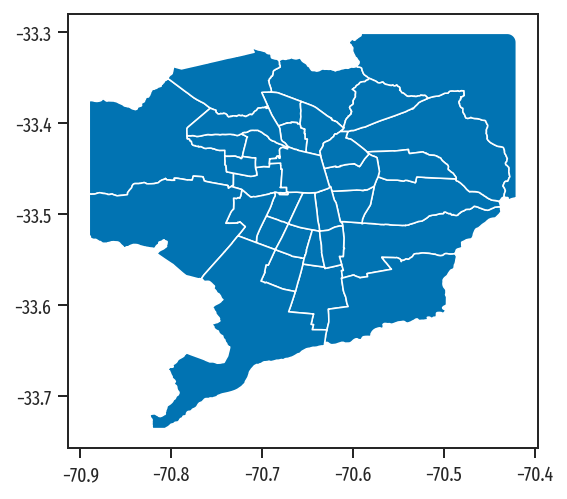

In [11]:
comunas_urbanas.plot()

Ya tenemos todo lo necesario para crear nuestra infografía. Comencemos.

### Vista General de la Movilidad en Santiago

La pregunta que podríamos responder detrás de la vista general es ¿cómo se ven las personas de Santiago a vuelo de pájaro? Es decir, ¿desde dónde hacia dónde se mueven? Vimos en la clase de redes que utilizar un gráfico `node_link` sobre un mapa permite responder esa pregunta: nos perimte saber desde dónde hacia dónde se viaja, pero también ver la densidad de la red de viajes y las comunas que concentran viajes.

Preparemos la matriz origen destino. Consideramos los viajes que:

- no sean de regreso a casa (porque son redundantes)
- sean entre comunas del radio urbano
- sean entre distintas comunas

Además consideraremos la importancia relativa de los viajes para _cada comuna_, de modo que mostremos los viajes representativos para cada origen, sin que una comuna con mayor población acapare más importancia en la visualización:

In [12]:
tph['Proposito'].value_counts()

volver a casa                   29251
Al trabajo                      11857
Al estudio                       5857
De compras                       3714
Trámites                         2718
Buscar o Dejar a alguien         2462
Visitar a alguien                1945
De salud                         1470
Recreación                       1360
Por trabajo                      1063
Otra actividad (especifique)     1061
Por estudio                       654
Comer o Tomar algo                311
Buscar o dejar algo               226
Name: Proposito, dtype: int64

In [13]:
from aves.features.utils import normalize_rows

matrix = (tph[(tph['Proposito'] != 'volver a casa') 
                              & (tph['ComunaOrigen'].isin(comunas_urbanas['NombreComuna']))
                              & (tph['ComunaDestino'].isin(comunas_urbanas['NombreComuna']))
                              & (tph['ComunaOrigen'] != tph['ComunaDestino'])
                              & (tph['ModoDifusion'] != 'Caminata')]
                .groupby(['ComunaOrigen', 'ComunaDestino'])
                .agg(n_viajes=('trip_weight', 'sum'))
                .unstack(fill_value=0)
                .pipe(normalize_rows)
                .stack()
                .reset_index()
                .pipe(lambda x: x[(x['n_viajes'] > 0)])
)

matrix

ComunaOrigen     ComunaDestino  n_viajes
2       Cerrillos          Conchalí  0.028309
3       Cerrillos         El Bosque  0.008612
4       Cerrillos  Estación Central  0.097668
6       Cerrillos     Independencia  0.011407
7       Cerrillos       La Cisterna  0.048292
...           ...               ...       ...
1150        Ñuñoa       San Joaquín  0.007849
1151        Ñuñoa        San Miguel  0.009956
1152        Ñuñoa         San Ramón  0.001690
1153        Ñuñoa          Santiago  0.236027
1154        Ñuñoa          Vitacura  0.018517

[985 rows x 3 columns]

Recordemos que para crear la red necesitamos asignar un identificador a cada comuna:

In [14]:
comunas_urbanas['node_id'] = range(len(comunas_urbanas))
comuna_to_node = dict(zip(comunas_urbanas['NombreComuna'], comunas_urbanas['node_id']))
matrix['source'] = matrix['ComunaOrigen'].map(comuna_to_node)
matrix['target'] = matrix['ComunaDestino'].map(comuna_to_node)

Ahora construimos la red. Dejaremos las aristas cuyo peso se encuentre en el quintil de representatividad más grande:

In [15]:
from aves.features.network import graph_from_pandas_edgelist

network, edge_weight = graph_from_pandas_edgelist(matrix[matrix['n_viajes'] > matrix['n_viajes'].quantile(0.8)], weight='n_viajes')
network.num_edges()

197

Creamos una instancia de `geographical_node_link` como vimos en clase:

In [16]:
from aves.visualization.maps import GeographicalNodeLink
from aves.visualization.figures import figure_from_geodataframe

geonodelink = GeographicalNodeLink(network, comunas_urbanas, node_column='node_id', edge_weight=edge_weight)

Y procedemos a graficar:

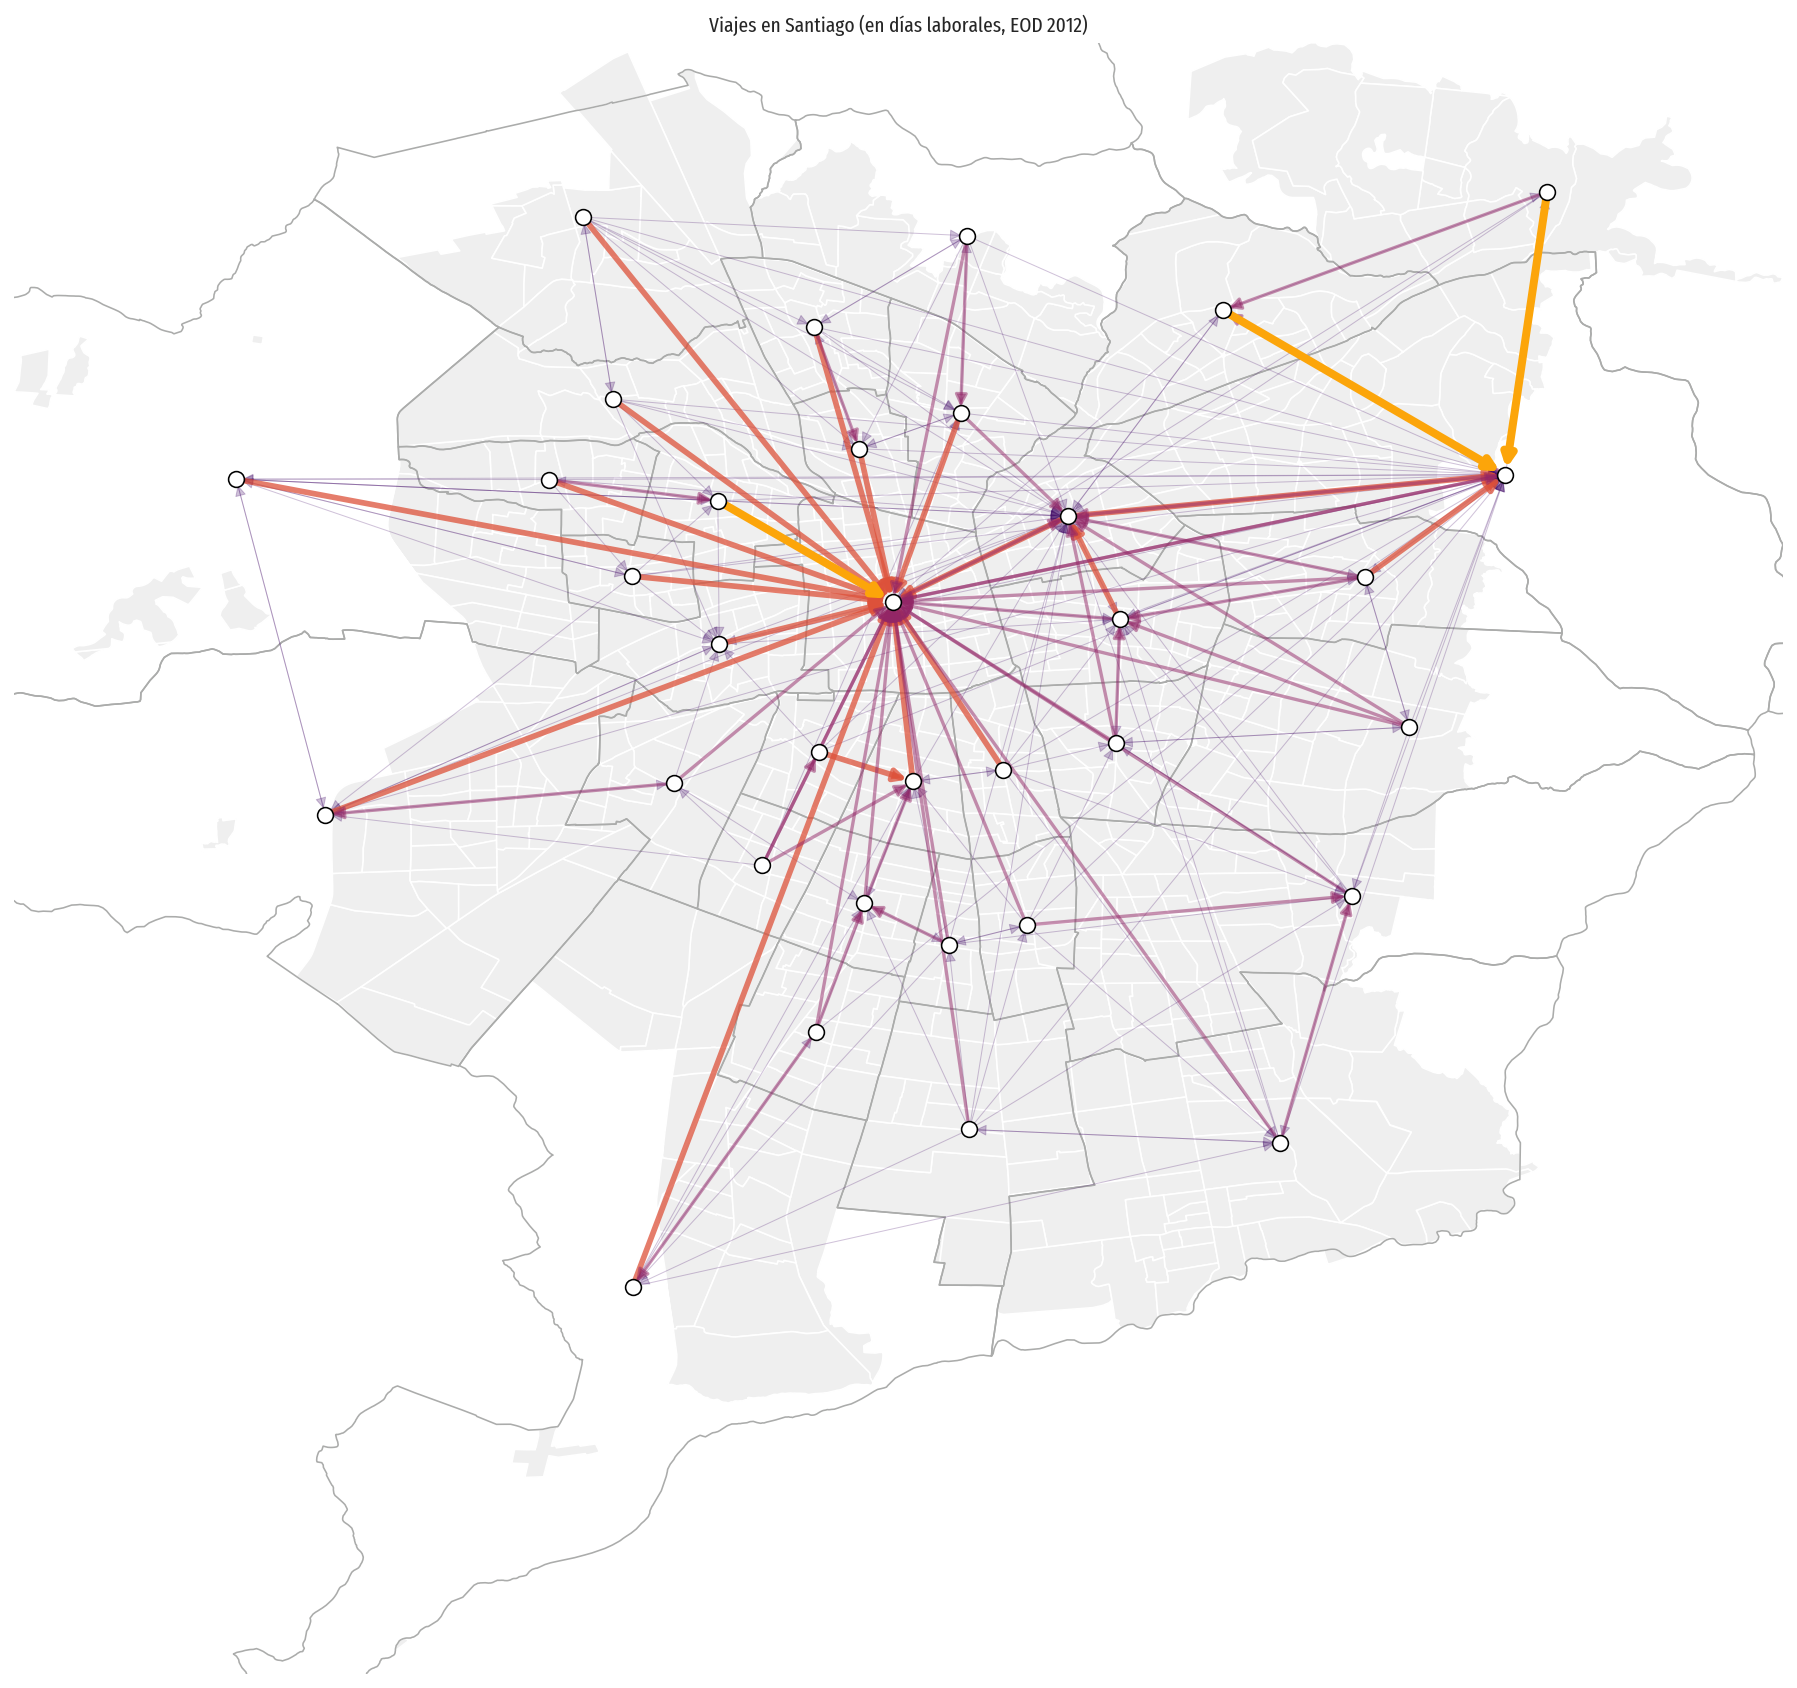

In [17]:
fig, ax = figure_from_geodataframe(zones, height=15, set_limits=True, remove_axes=True)

zones.plot(ax=ax, facecolor='#efefef', edgecolor='white', zorder=0)
comunas_urbanas.plot(ax=ax, facecolor='none', edgecolor='#abacab', zorder=0)

geonodelink.plot_nodes(ax, color='white', edgecolor='black', size=250)
geonodelink.plot_weighted_edges(ax, palette='inferno', log_transform=True, weight_bins=4,
                                min_linewidth=0.5, linewidth=4, min_alpha=0.25, alpha=1.0, 
                                with_arrows=True, arrow_shrink=3, arrow_scale=12)

ax.set_title('Viajes en Santiago (en días laborales, EOD 2012)');

Este gráfico es complejo, puesto que tiene muchas marcas que se cruzan entre sí. Pero invita a observarlo y mirarlo con detalle, a explorar las relaciones entre comunas, a buscar las comunas que concentran flujos (flechas), a buscar transiciones entre comunas, a resaltarlas comunas que no atraen viajes, y más. Por tanto, como **vista general** es un gran punto de partida.

### Vista Filtrada: Grupos de Hogares

Hasta ahora nuestra unidad de análisis han sido los viajes y los flujos.

En la segunda visualización dividiremos los hogares de Santiago en cinco grupos de acuerdo a su nivel de ingreso.

Utilizaremos el método `qcut` de `pandas`, cuyo nombre significa _quantile cut_ o dividir el `DataFrame` en percentiles. Le pediremos 5 grupos que se almacenarán en la columna `home_category`:

In [18]:
h['home_category'] = pd.qcut(h['IngresoHogar'], 5)
h['home_category'].value_counts(sort=False)

(-0.001, 250000.0]        3702
(250000.0, 416938.2]      3604
(416938.2, 617565.0]      3652
(617565.0, 950016.0]      3653
(950016.0, 14800000.0]    3653
Name: home_category, dtype: int64

Observamos que el método elige los límites de ingreso de cada grupo de manera que la cantidad de hogares sea similar en cada uno.

Cuando tenemos grupos como estos, una de las primeras preguntas que podemos hacer es: ¿cómo se distribuyen geográficamente estos grupos?¿Están concentrados en ciertas áreas de la ciudad?

Para responderlo, lo primero que debemos hacer es generar un `GeoDataFrame`:

<AxesSubplot:>

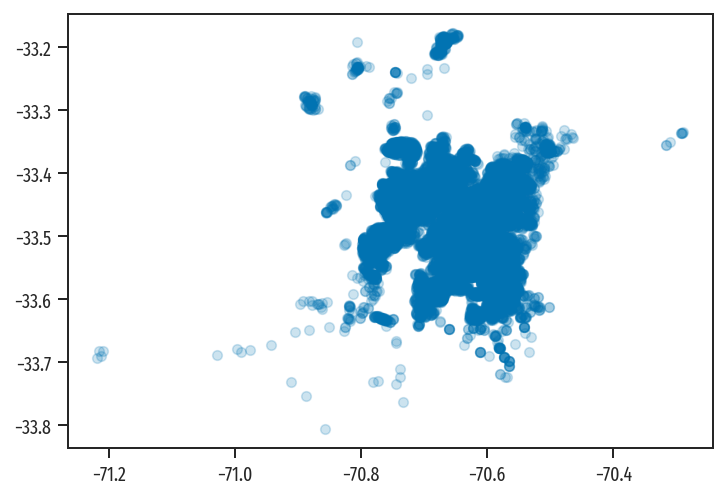

In [19]:
from aves.features.geo import to_point_geodataframe

geo_h = to_point_geodataframe(h[h['Hogar'].isin(tp['Hogar'])], 'DirCoordX', 'DirCoordY', crs='epsg:32719').to_crs(zones.crs)
geo_h.plot(alpha=0.2)

En la clase de mapas vimos que para visualizar distribución geográfica de un conjunto de puntos podemos utilizar un `heat_map`, que nos mostrará "áreas de calor" donde hay mayor concentración de hogares.

Podemos hacer una prueba rápida para ver como luce esta propuesta:

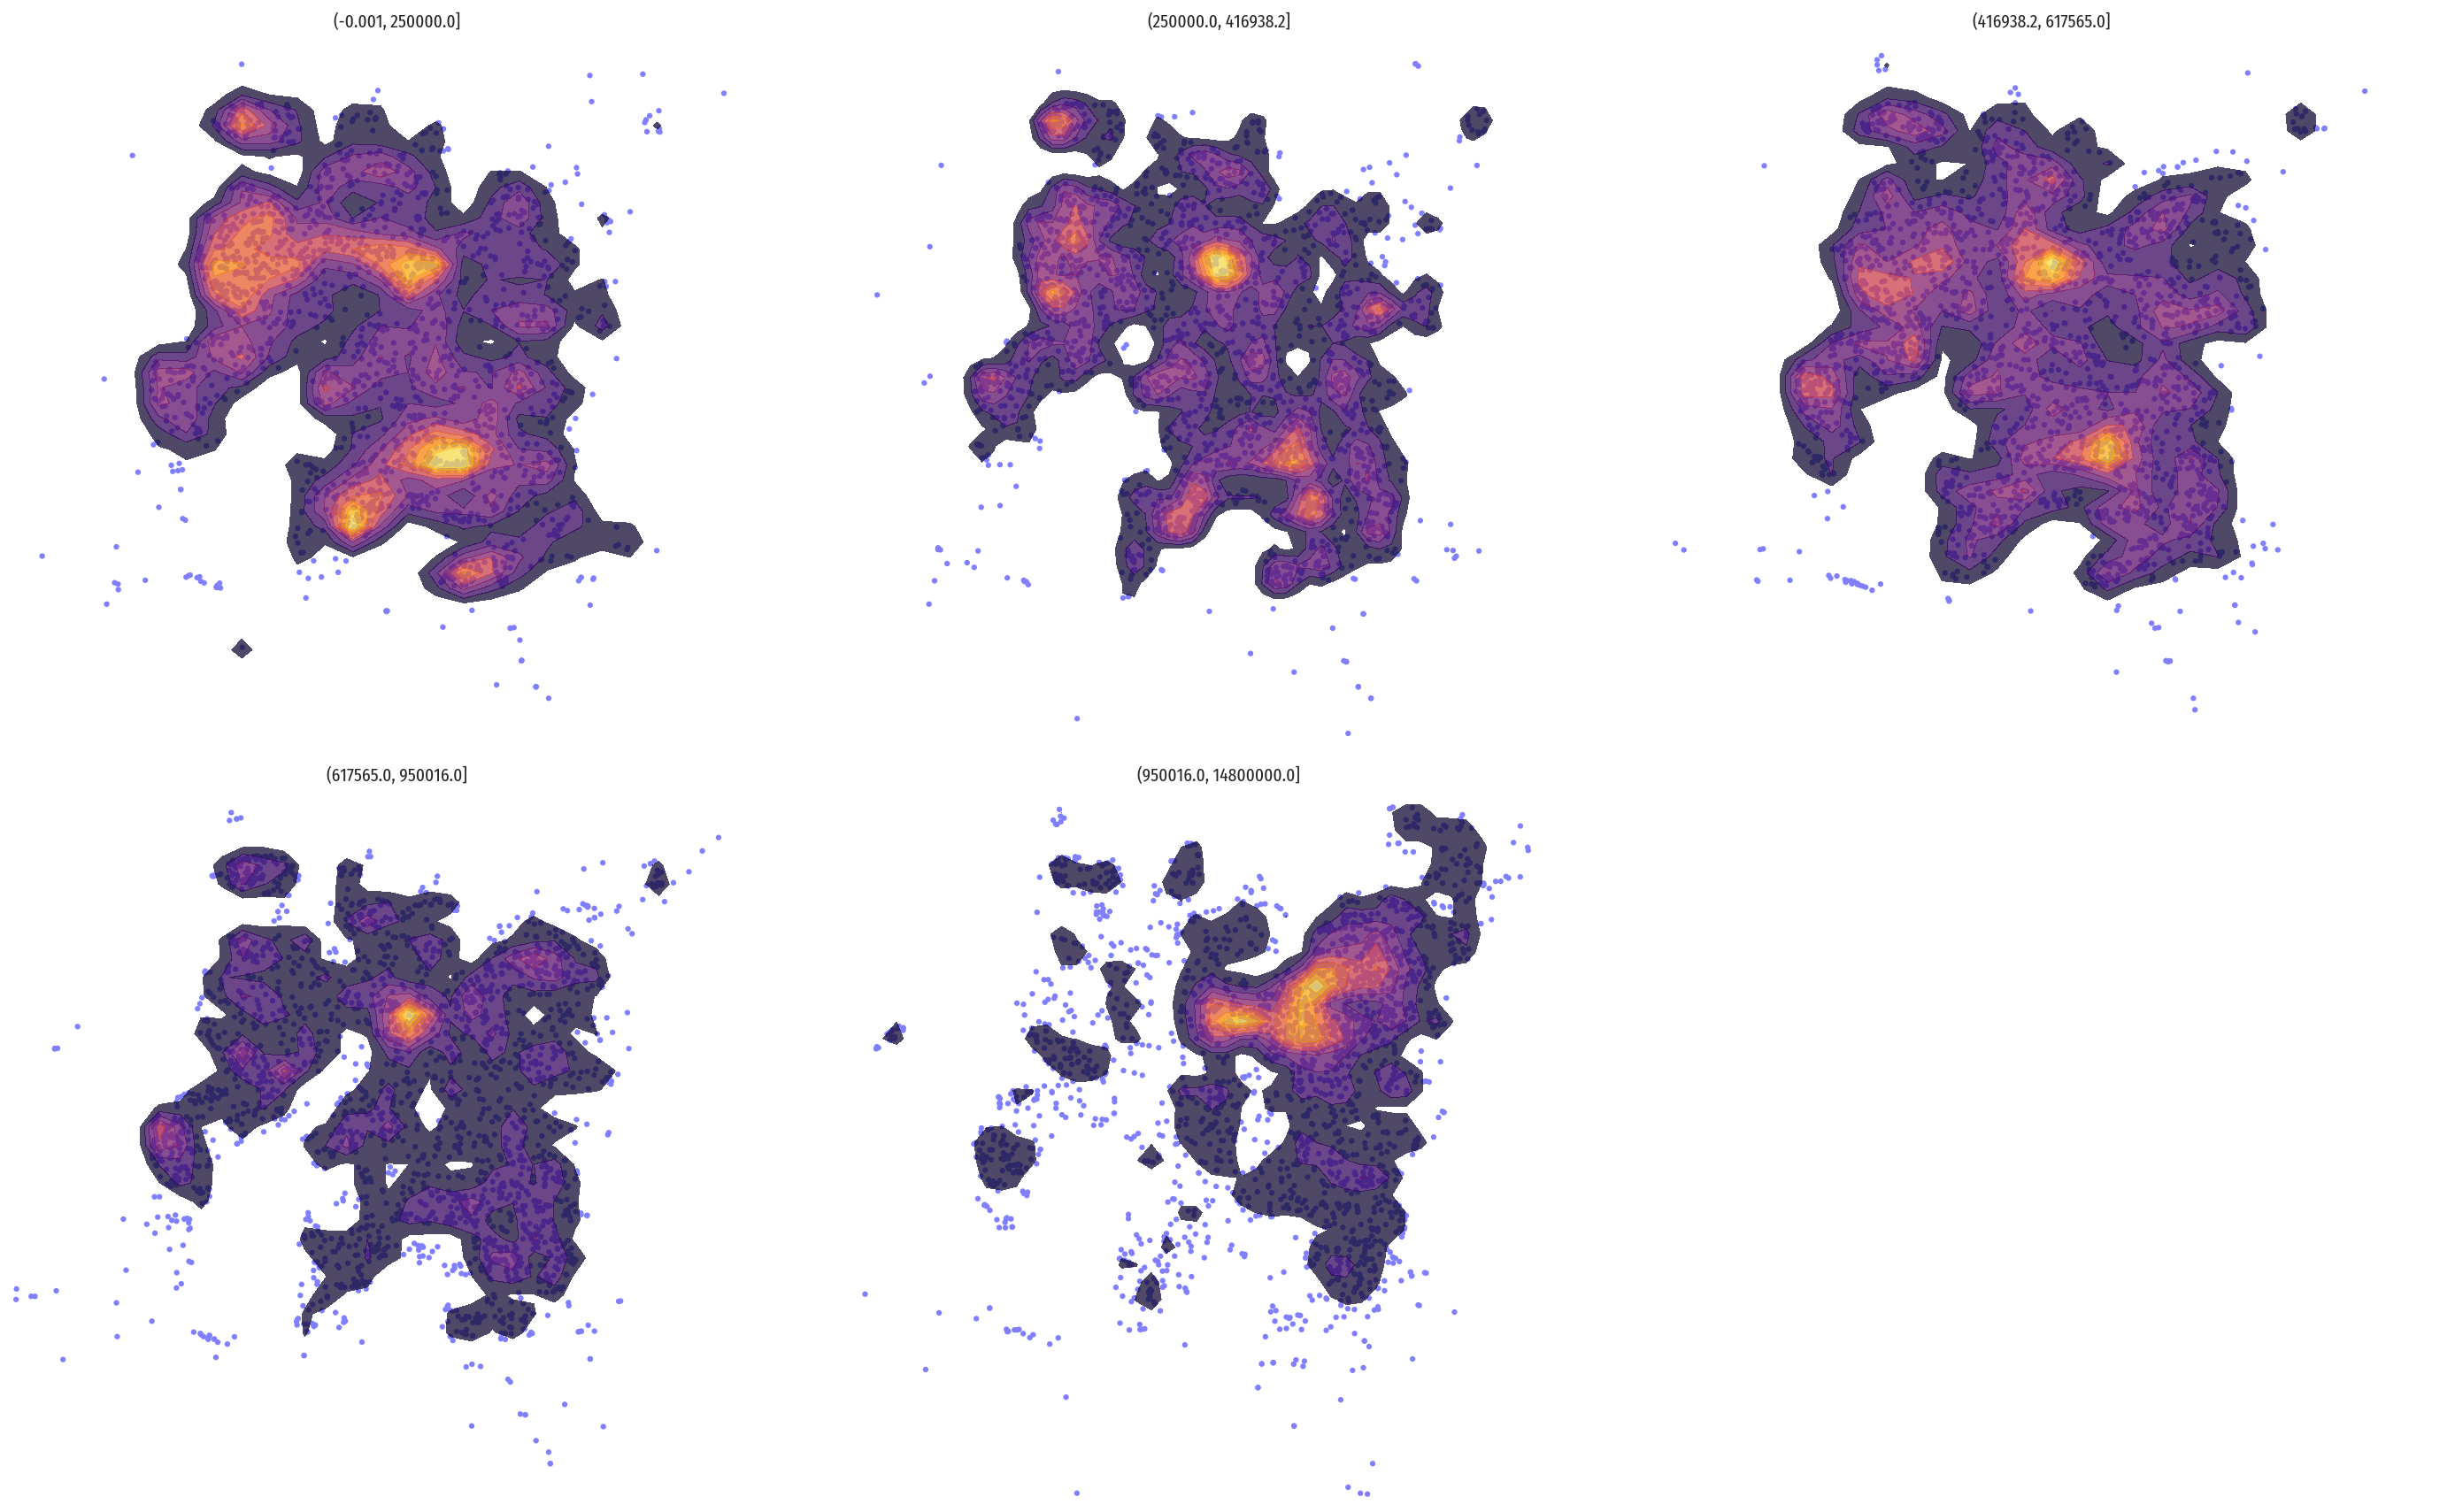

In [20]:
from aves.visualization.figures import small_multiples_from_geodataframe, tighten_figure
from aves.visualization.maps import bubble_map, dot_map, heat_map

fig, axes = small_multiples_from_geodataframe(zones, 5, height=6, col_wrap=3, remove_axes=True)

for ax, home_cat in zip(axes, geo_h['home_category'].cat.categories):
    ax.set_title(home_cat)
      
    temp_geodf = geo_h[geo_h['home_category'] == home_cat]
    
    dot_map(ax, temp_geodf)  
    heat_map(ax, temp_geodf, n_levels=10,
             weight_column='FactorHogar', alpha=0.75, palette='inferno',
             # área de influencia
             bandwidth=0.005,
             # no pintar áreas con valores muy bajos
             low_threshold=0.1)

fig.tight_layout()

Notamos que sí existe concentración geográfica de los tipos de hogar. Entonces, lo que haremos en nuestra infografía es utilizar estos mapas con dos propósitos. El primero es mostrar la distribución geográfica de los hogares, el segundo es ser leyenda para visualizaciones complementarias para cada uno de estos grupos.

### Visualización Complementaria (Detalle) #1: Tiempos de Viaje al Trabajo

Una pregunta que podríamos hacernos respecto a cada grupo es a qué hora se van al trabajo. ¿Cuáles se van más temprano?¿Cuáles más tarde?

Podemos resolver esta pregunta visualizando la distribución de cada grupo. Como tenemos pesos para cada viaje, debemos tener cuidado de estimarla considerándolos. Para ello podemos usar el paquete `KDEpy`.

Lo primero que haremos será: 

- agregar la categorización de hogares a la tabla de viajes,
- convertir la hora de inicio de los viajes en un número.

Lo hacemos así:

In [21]:
tph_categorized = tph.merge(h)
tph_categorized['HoraDeInicio'] = tph_categorized['HoraIni'] / pd.Timedelta(hours=1)

Ahora calculamos la _Kernel Density Estimation_ para todos los viajes al trabajo:

In [22]:
import KDEpy

def kde_work_trips(df):
    x, y = KDEpy.FFTKDE().fit(df[(df['Proposito'] == 'Al trabajo')]['HoraDeInicio'].values, weights=df[(df['Proposito'] == 'Al trabajo')]['trip_weight'].values)(2**10)
    return x, y

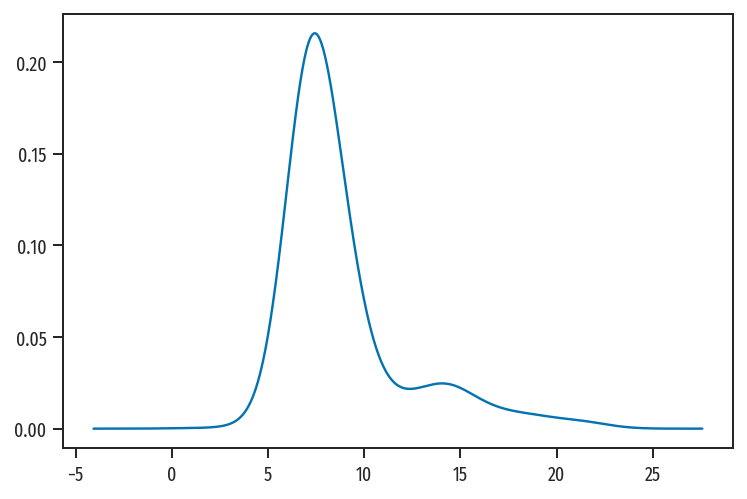

In [23]:
all_x_work, all_y_work = kde_work_trips(tph_categorized)
plt.plot(all_x_work, all_y_work, label=home_cat)

Vemos que funciona. 

Hagamos lo mismo, esta vez para cada categoría de hogar:

(-0.001, 250000.0], salida al trabajo característica: 7:05 hrs.
(250000.0, 416938.2], salida al trabajo característica: 7:06 hrs.
(416938.2, 617565.0], salida al trabajo característica: 7:16 hrs.
(617565.0, 950016.0], salida al trabajo característica: 7:22 hrs.
(950016.0, 14800000.0], salida al trabajo característica: 7:40 hrs.


(0.0, 24.0)

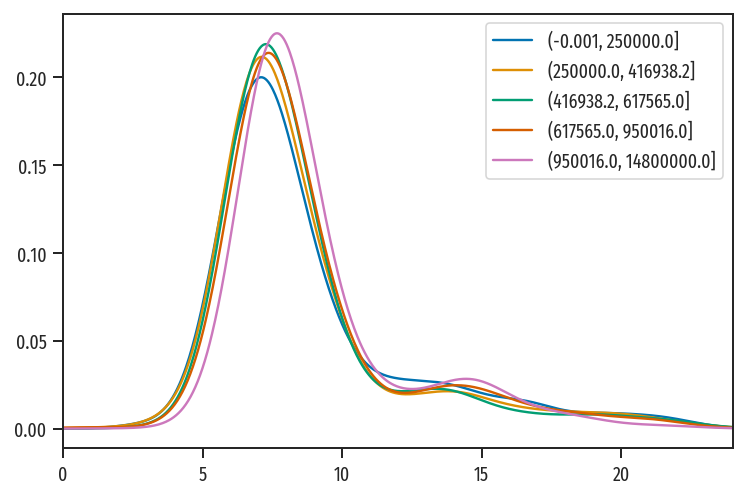

In [24]:
fig, ax = plt.subplots()

for home_cat in tph_categorized['home_category'].cat.categories:
    temp_df = tph_categorized[(tph_categorized['home_category'] == home_cat) & (tph_categorized['Proposito'] == 'Al trabajo')]
    x, y = kde_work_trips(temp_df)
    ax.plot(x, y, label=home_cat)
    
    dt = pd.Timedelta(hours=pd.Series(y, index=x).idxmax())    
    print(f'{home_cat}, salida al trabajo característica: {dt.components.hours}:{str(dt.components.minutes).zfill(2)} hrs.')
    
ax.legend()
ax.set_xlim([0, 24])

Nos damos cuenta que hay unas horas más interesantes que otra. Fíjemonos solamente en el rango entre 4 y 11AM:

(-0.001, 250000.0], salida al trabajo característica: 7:05 hrs.
(250000.0, 416938.2], salida al trabajo característica: 7:06 hrs.
(416938.2, 617565.0], salida al trabajo característica: 7:16 hrs.
(617565.0, 950016.0], salida al trabajo característica: 7:22 hrs.
(950016.0, 14800000.0], salida al trabajo característica: 7:40 hrs.


(4.0, 11.0)

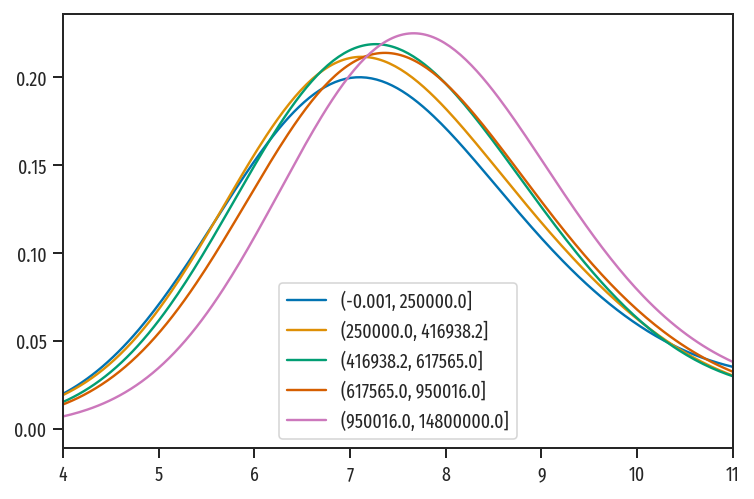

In [25]:
fig, ax = plt.subplots()

for home_cat in geo_h['home_category'].cat.categories:
    temp_df = tph_categorized[(tph_categorized['home_category'] == home_cat) & (tph_categorized['Proposito'] == 'Al trabajo')]
    x, y = kde_work_trips(temp_df)
    ax.plot(x, y, label=home_cat)
    
    dt = pd.Timedelta(hours=pd.Series(y, index=x).idxmax())    
    print(f'{home_cat}, salida al trabajo característica: {dt.components.hours}:{str(dt.components.minutes).zfill(2)} hrs.')
    
ax.legend()
ax.set_xlim([4, 11])

¡Hay diferencias! Será interesante mostrarlas en la visualización.

### Visualización Complementaria (Detalle) #2: Modos de Viaje

Podríamos preguntarnos si las distintas tipologías de hogares se desplazan de manera distinta por la ciudad. ¿Es el uso de bicicleta distinto por grupos de ingreso?¿El uso de automóvil? Existen preconcepciones al respecto (como que la bicicleta es un modo de transporte de pobres o de hipsters) que podemos aclarar utilizando visualización.

Para obtener la respuesta utilizaremos la columna `ModoDifusion` de los viajes. No trabajaremos con todos los modos, descartaremos los que no podemos saber a qué se refieren ("Otros"):

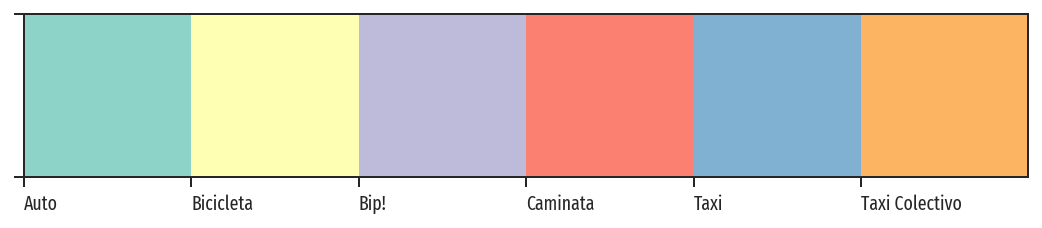

In [26]:
modes = sorted(set(tph['ModoDifusion'].unique()) - set(['Bip! - Otros Privado', 'Bip! - Otros Público', 'Otros']))
mode_colors = sns.color_palette('Set3', n_colors=len(modes))
sns.palplot(mode_colors, size=1.5)
plt.gca().set_xticklabels(modes, ha='left');

Ahora que tenemos identificados los modos que queremos visualizar, y hasta les hemos asignado un color, podemos ver la distribución _parte-de-un-todo_ dentro de cada categoría de hogar utilizando un `stacked_bar_chart`:

<AxesSubplot:ylabel='home_category'>

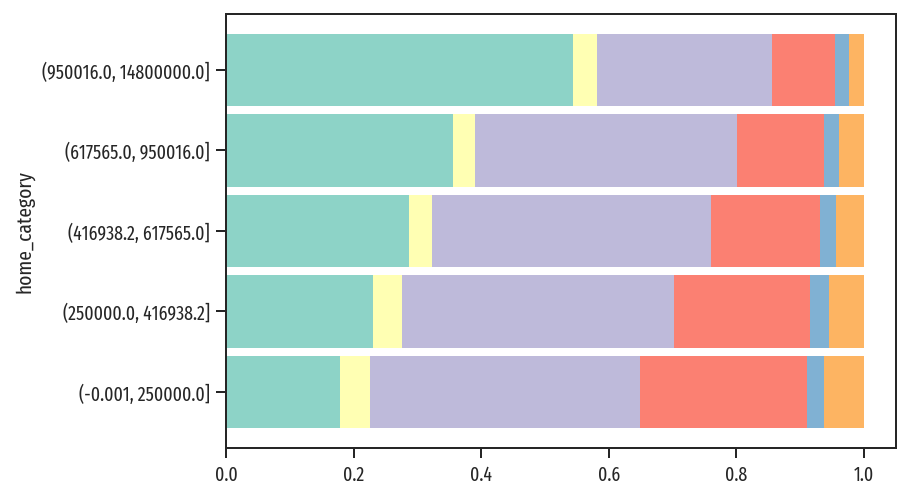

In [27]:
from aves.features.utils import normalize_rows

mode_distributions = (tph_categorized.groupby(['home_category', 'ModoDifusion'])['trip_weight']
 .sum()
 .unstack(fill_value=0)
 [modes]
 .pipe(normalize_rows)
)

mode_distributions.plot(kind='barh', width=0.9, edgecolor='none', color=mode_colors, stacked=True, legend=False)

¡Observamos que hay diferencias en prácticamente todos los modos de transporte, excepto en _taxi_ y _bicicleta_! Ciertamente es un tema que llama a la discusión. Sin embargo, como estamos realizando una infografía que explora distintas temáticas de manera transversal, no profundizaremos en este tema. Nos moveremos al siguiente aspecto que queremos analizar.

### Visualización Complementaria (Detalle) #3: Propósitos de Viaje

Asimismo, podríamos preguntarnos si las distintas tipologías de hogares tienen _estilos de vida_ distintos. Por ejemplo, ¿la proporción de viajes de recreación en cada categoría de hogar es similar? 

De manera análoga a la visualización anterior utilizaremos la columna `Proposito` de los viajes:

In [28]:
tph['Proposito'].unique()

array(['volver a casa', 'Visitar a alguien', 'Al trabajo', 'Al estudio',
       'Buscar o Dejar a alguien', 'De compras', 'Trámites',
       'Por estudio', 'Otra actividad (especifique)', 'De salud',
       'Recreación', 'Comer o Tomar algo', 'Por trabajo',
       'Buscar o dejar algo'], dtype=object)

Del mismo modo, no trabajaremos con todos los propósitos. Por ejemplo, podemos descartar aquellos cuyo destino no depende de las intenciones de la persona que hace el viaje, o bien, aquellos que son triviales (como volver a casa):

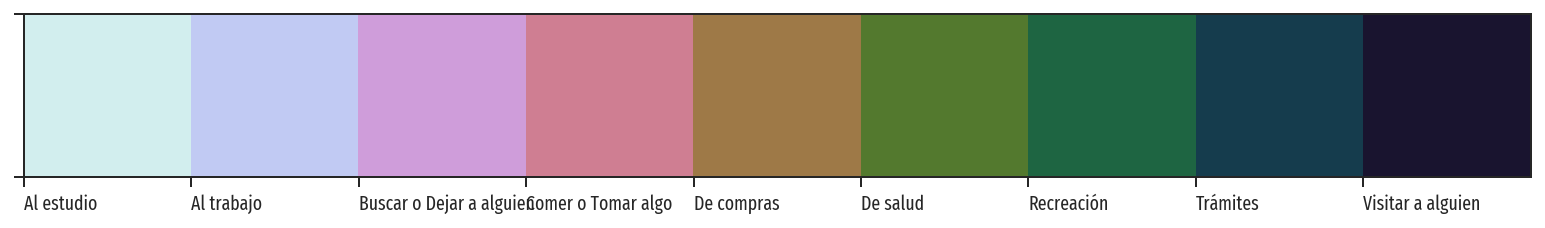

In [29]:
purposes = sorted(set(tph['Proposito'].unique()) - set(['Por trabajo', 'Por estudio', 'Otra actividad (especifique)', 'volver a casa', 'Buscar o dejar algo']))
purpose_colors = sns.color_palette('cubehelix_r', n_colors=len(purposes))
sns.palplot(purpose_colors, size=1.5)
plt.gca().set_xticklabels(purposes, ha='left');

Similarmente, ahora que tenemos identificados los propósitos que queremos visualizar, y hasta les hemos asignado un color, podemos ver la distribución _parte-de-un-todo_ dentro de cada categoría de hogar utilizando un `stacked_bar_chart`:

<AxesSubplot:ylabel='home_category'>

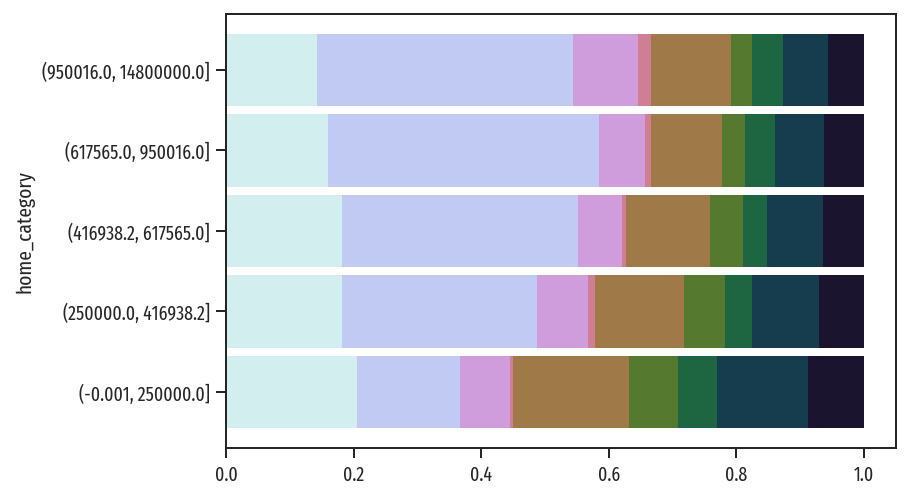

In [30]:
purpose_distributions = (tph_categorized
 .groupby(['home_category', 'Proposito'])
 ['trip_weight']
 .sum()
 .unstack(fill_value=0)
 [purposes]
 .pipe(normalize_rows)
)

purpose_distributions.plot(kind='barh', width=0.9, edgecolor='none', stacked=True, legend=False, color=purpose_colors)

Notamos que hay diferencias en la distribución en cada grupo. Por ejemplo, ¡el grupo de menor ingreso tiene menos viajes al trabajo! ¿Es esto porque trabajan menos? No necesariamente. Puede ser porque tiene una composición etárea distinta, como más gente jubilada, o más gente joven. ¡Es una pregunta que queda para el futuro! 

### Composición de Visualizaciones en una Grilla

En este momento ya tenemos suficientes visualizaciones para organizar en una grilla y crear una narrativa. Pero, ¿cómo lo hacemos en Python?

La respuesta es el módulo `gridspec` que permite especificar una grilla sobre la cual dibujar. Como este notebook busca ejemplificar la creación de una infografía y no los detalles de este módulo de `matplotlib`, dejaremos disponible un enlace a un [tutorial de `gridspec`](https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html) sin ahondar en detalles.

Lo primero que debemos considerar es que ya no podemos usar los métodos auxiliares para configurar figuras de `aves`, porque no son compatibles con `gridspec`. Así que debemos configurar la grilla manualmente. Por eso necesitamos conocer el _radio de aspecto_ del mapa de Santiago, a partir de la variable `bounding_box` que habíamos calculado antes:

In [31]:
bounding_box

array([-70.88006218, -33.72603779, -70.43015094, -33.31109652])

In [32]:
map_aspect_ratio = (bounding_box[2] - bounding_box[0]) / (bounding_box[3] - bounding_box[1])
map_aspect_ratio

1.0842769129143404

Así se crea y configura la estructura de nuestra infografía. Primero, importamos `gridspec`:

In [33]:
import matplotlib.gridspec as gridspec

Luego, configuramos los radios de aspecto que tendrán cada fila y columna de la grilla. Como tenemos cinco categorías de hogares, la grilla tendrá cinco columnas de igual ancho. Cada columna tendrá las visualizaciones de una categoría de hogar específica:

In [34]:
width_ratios = [1.0, 1.0, 1.0, 1.0, 1.0]

Por otro lado, como tenemos un mapa más grande que los demás, ese mapa utilizará más espacio. Tenemos cinco filas en total (overview, `heat_map`, `KDE`, `stacked_bar_chart`, `stacked_bar_chart`) y agregaremos dos filas extra para incorporar la leyenda de los `stacked_bar_chart`). Así, la altura de cada fila de la grilla no será constante:

In [35]:
height_ratios = [5.0, 1.0, 0.4, 0.3, 0.1, 0.3, 0.1]

Finalmente procedemos a graficar la grilla. Las variables `h_space` y `w_space` se refieren al espacio entre cada fila y cada columna, que permite agregar texto (como etiquetas de ejes y títulos). La variable `fig_scale` la utilizaremos para determinar el tamaño final de la visualización. Noten que los `width_ratios` y `height_ratios` los multiplicamos por el radio de aspecto del mapa, de modo que el mapa no se vea deformado.

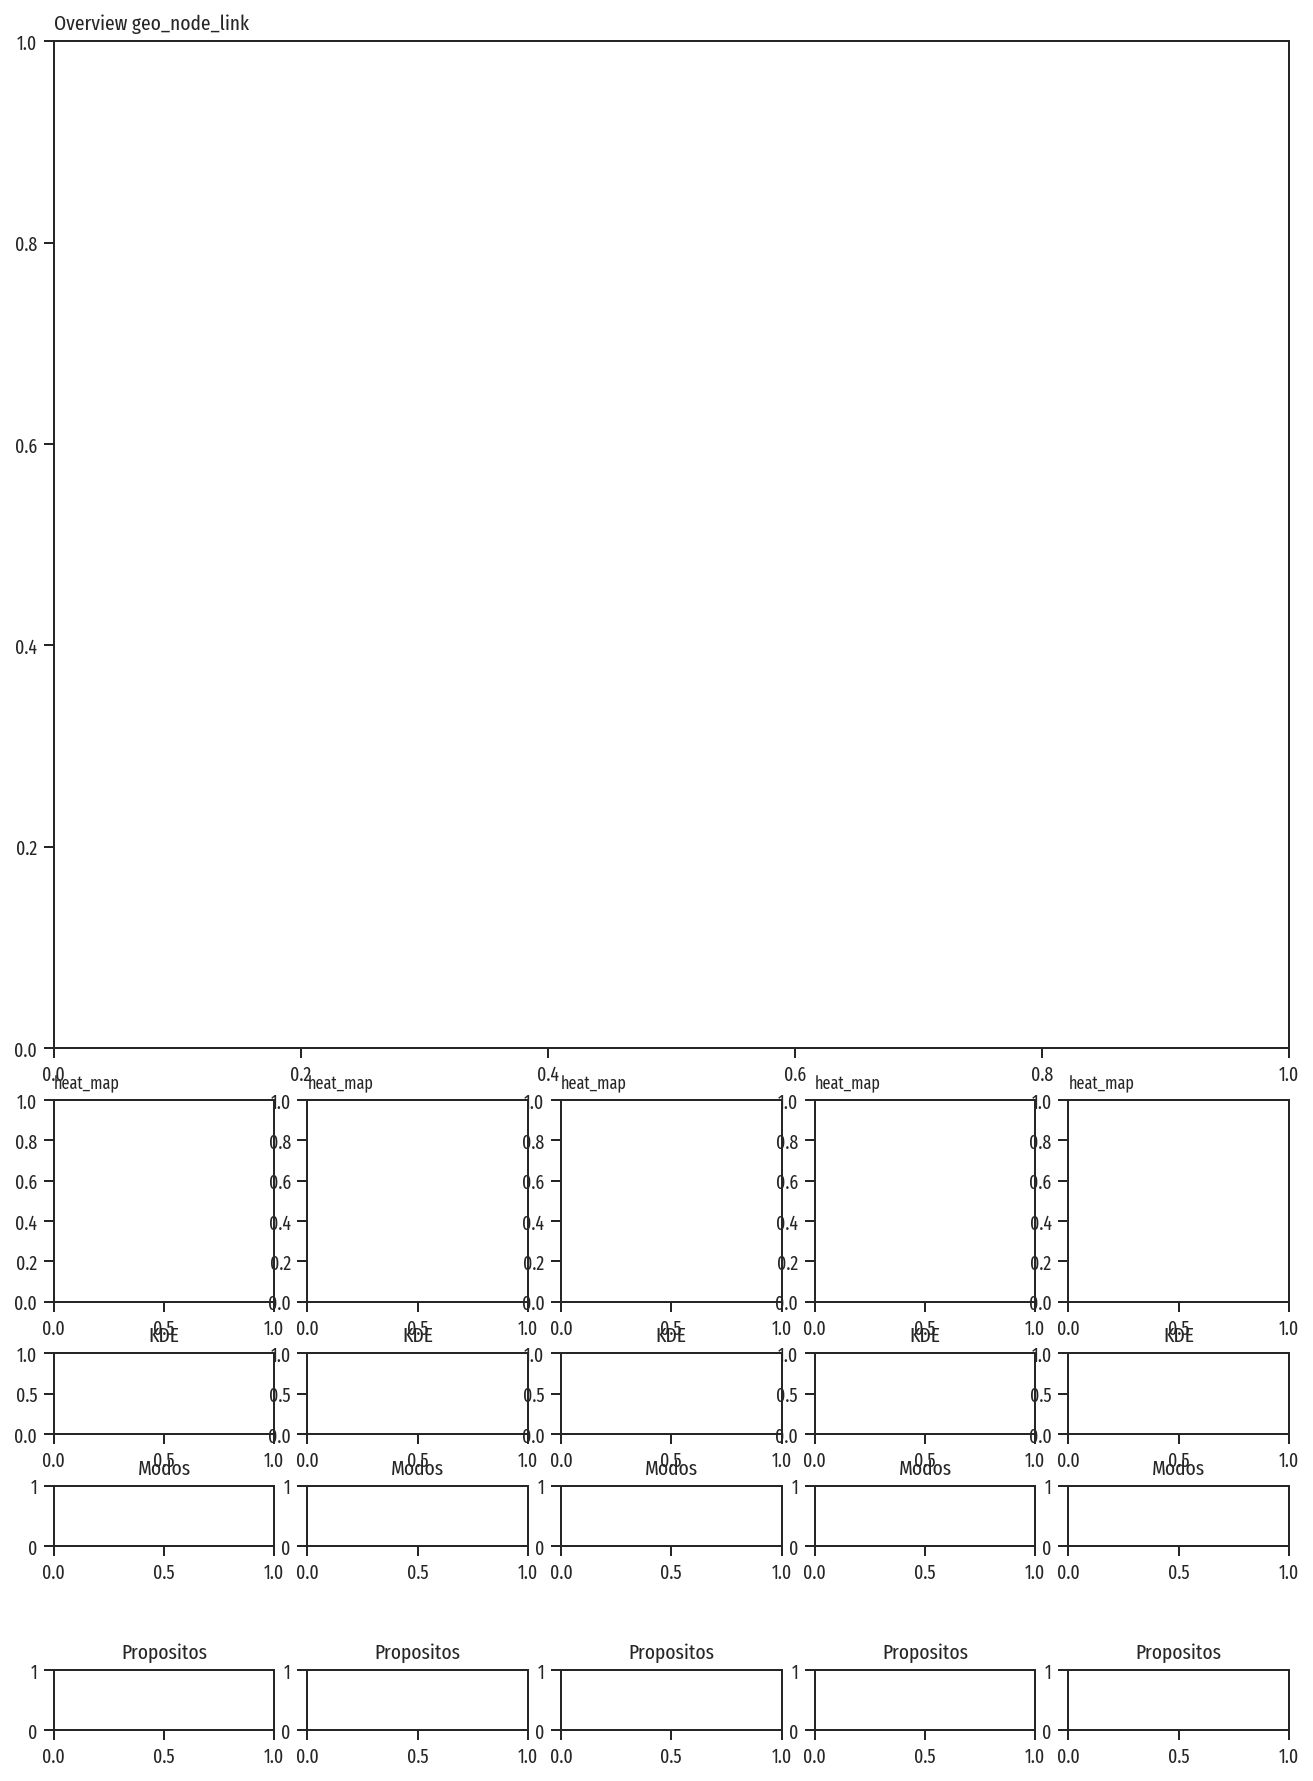

In [36]:
fig_scale = 2
h_space = 0.25
w_space = 0.15

y_size = (sum(height_ratios) + (len(height_ratios) - 1) * w_space) * fig_scale
x_size = (sum(width_ratios) + (len(width_ratios) - 1) * h_space) / map_aspect_ratio * fig_scale


fig = plt.figure(figsize=(x_size, y_size))

gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), figure=fig, hspace=h_space, wspace=w_space, 
                       width_ratios=width_ratios,
                       height_ratios=height_ratios)

# La visualización overview utiliza la primera fila (0) y las 5 columnas (0:5)
ax_overview = fig.add_subplot(gs[0, 0:5])
ax_overview.set_title('Overview geo_node_link', loc='left')

for i, cat in enumerate(geo_h['home_category'].cat.categories):
    heatmap_ax = fig.add_subplot(gs[1, i])    
    heatmap_ax.set_title('heat_map', loc='left', fontsize='small')
    
    kde_ax = fig.add_subplot(gs[2, i])
    kde_ax.set_title('KDE')

    mode_ax = fig.add_subplot(gs[3, i])
    mode_ax.set_title('Modos')

    purpose_ax = fig.add_subplot(gs[5, i])
    purpose_ax.set_title('Propositos')


¡Ésa será la organización de nuestra visualización! Ahora debemos agregar el código correspondiente a cada visualización y configurar los ejes para que se vean bien. Lo haremos en la siguiente celda, donde también utilizaremos la función `categorical_color_legend` para agregar las leyendas de color de cada `stacked_bar_chart`:

/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


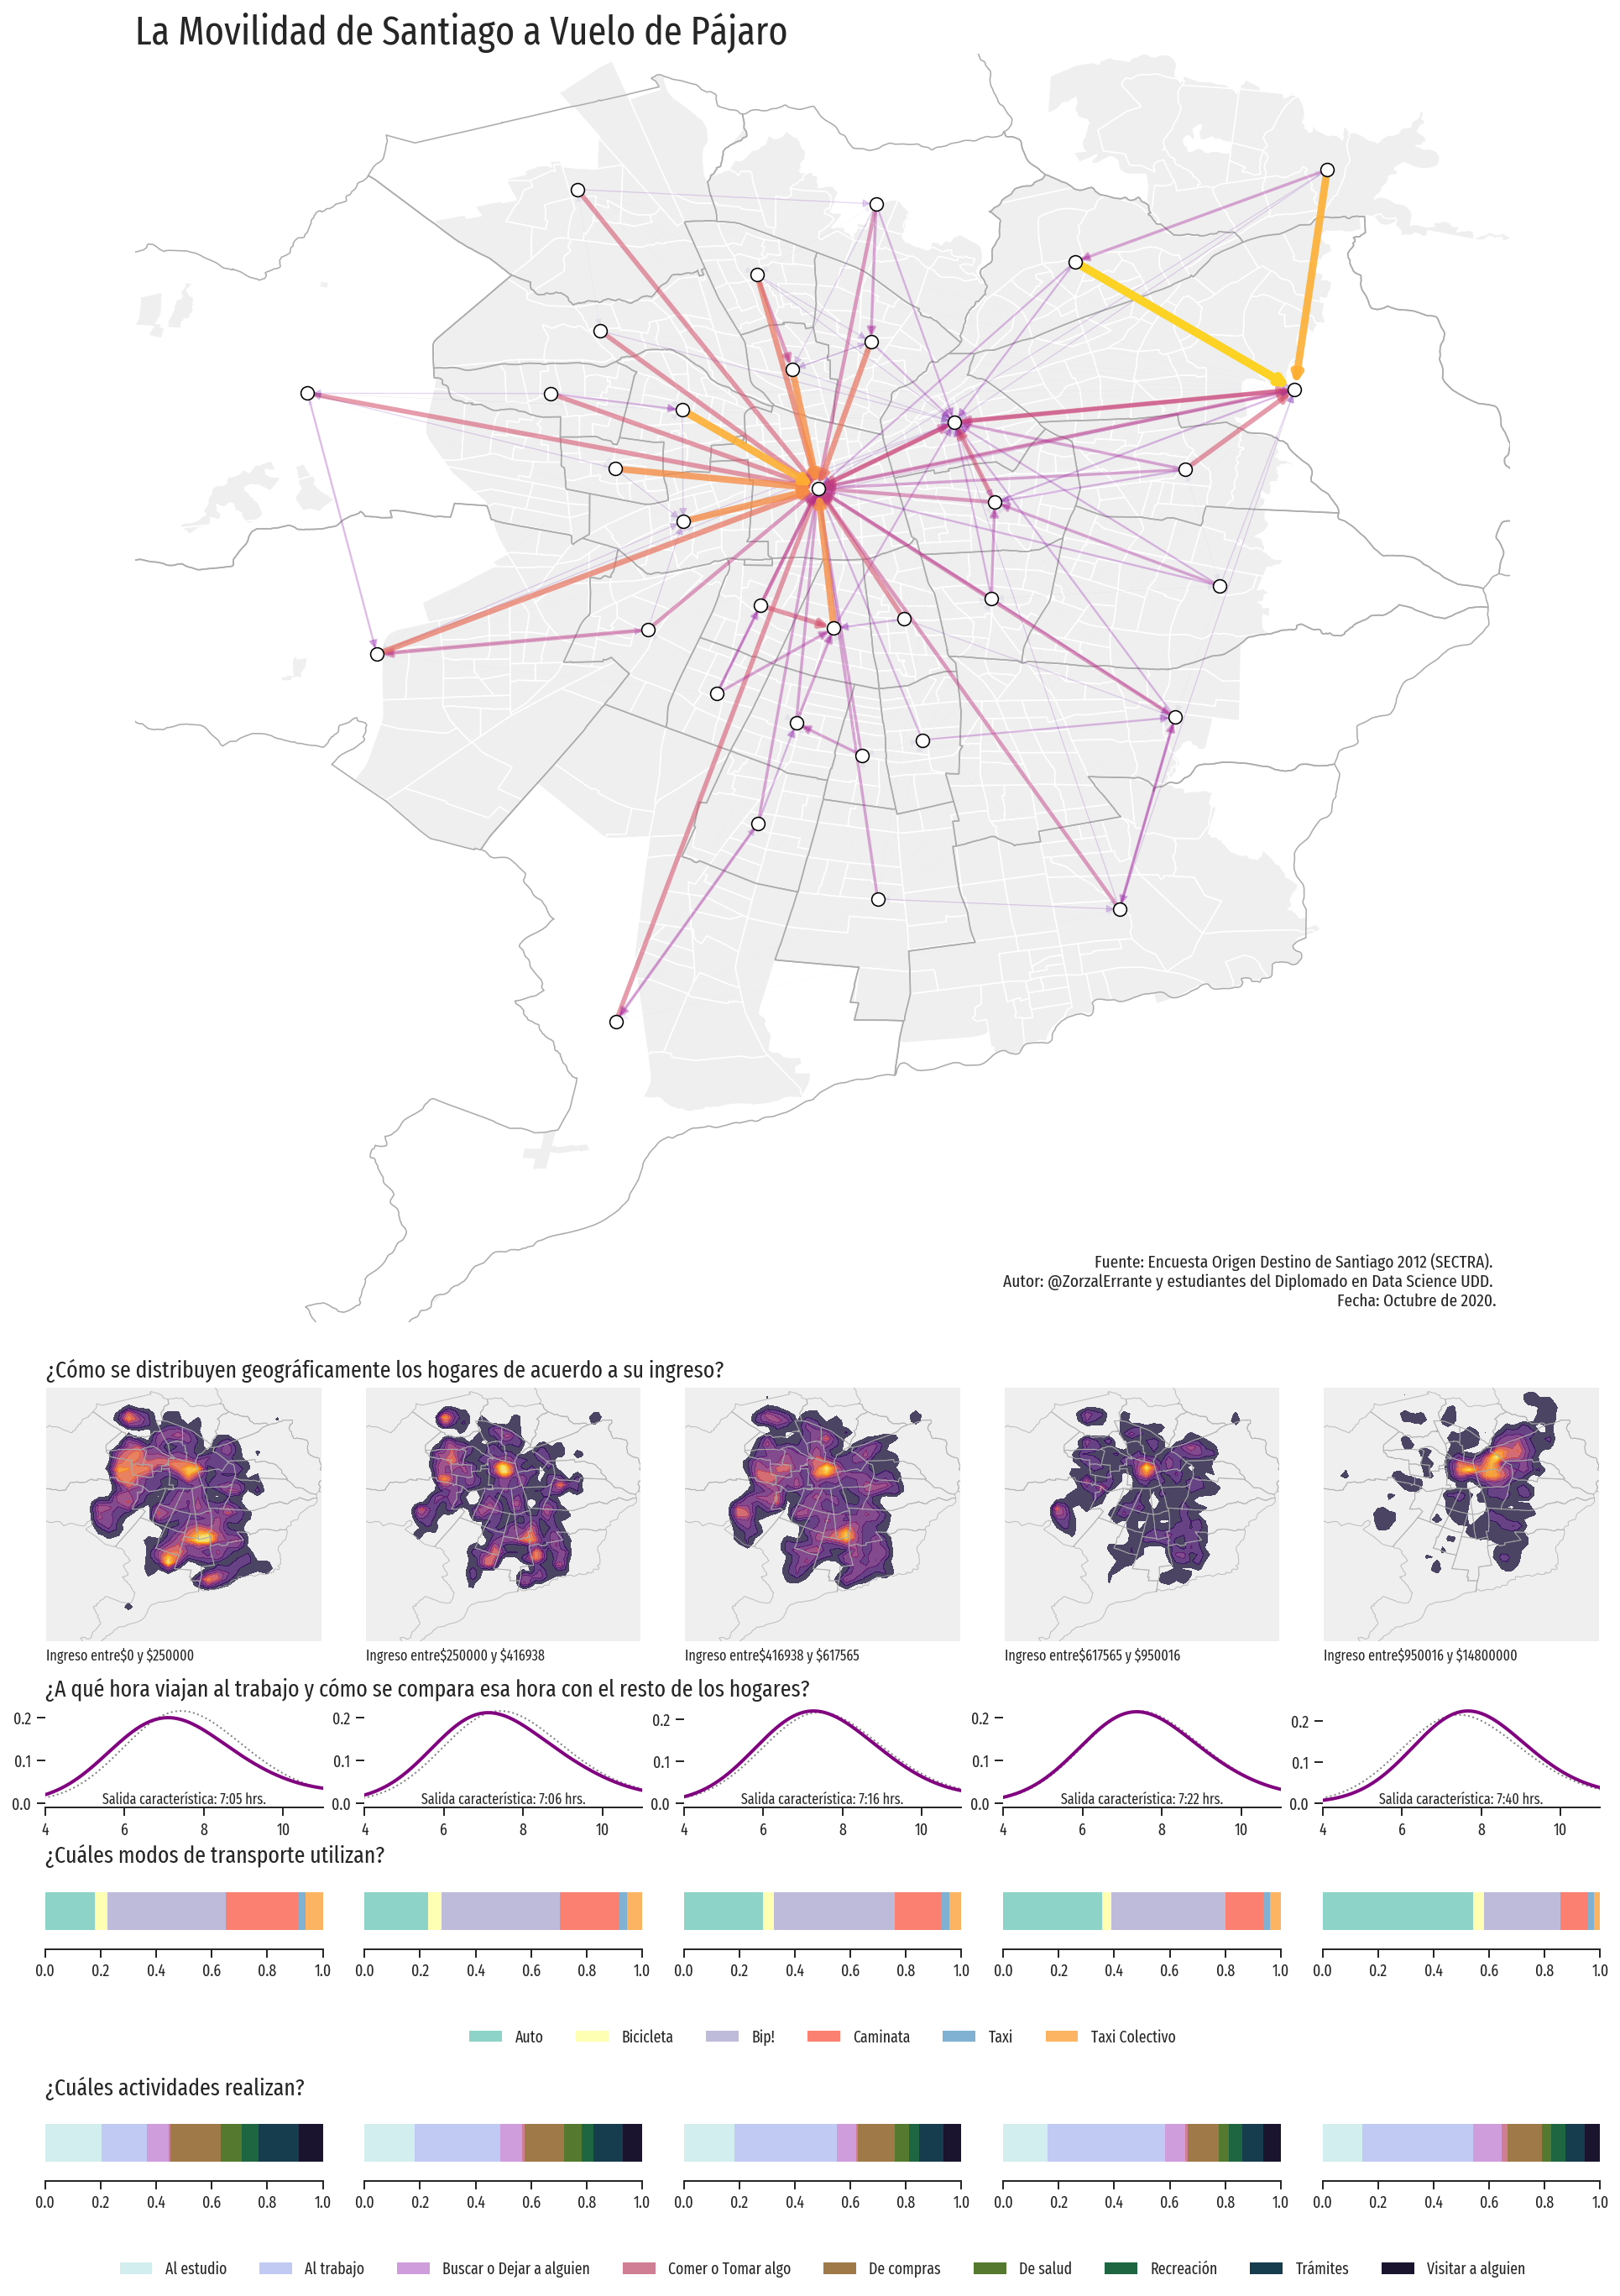

In [38]:
from aves.visualization.colors import categorical_color_legend

fig_scale = 3

y_size = (sum(height_ratios) + (len(height_ratios) - 1) * w_space) * fig_scale
x_size = (sum(width_ratios) + (len(width_ratios) - 1) * h_space) / map_aspect_ratio * fig_scale

fig = plt.figure(figsize=(x_size, y_size))

gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), figure=fig, hspace=h_space, wspace=w_space, 
                       width_ratios=width_ratios,
                       height_ratios=height_ratios)

# Overview 
ax_overview = fig.add_subplot(gs[0, 0:5])
ax_overview.set_title('La Movilidad de Santiago a Vuelo de Pájaro', loc='left', fontsize=24)

# fondo del overview
zones.plot(ax=ax_overview, facecolor='#efefef', edgecolor='white', zorder=0)
comunas_urbanas.plot(ax=ax_overview, facecolor='none', edgecolor='#abacab', zorder=0)

# gráfico de red
geonodelink.plot_nodes(ax_overview, color='white', edgecolor='black', size=250)
geonodelink.plot_weighted_edges(ax_overview, palette='plasma', log_transform=True, weight_bins=10,
                                min_linewidth=0.1, linewidth=5, min_alpha=0.05, alpha=1.0, 
                                with_arrows=True, arrow_shrink=3, arrow_scale=10)

# configuración manual del eje: quitamos detalles, configuramos límites
ax_overview.set_axis_off()
ax_overview.set_xlim([bounding_box[0], bounding_box[2]])
ax_overview.set_ylim([bounding_box[1], bounding_box[3]])

# notas sobre el dataset
ax_overview.annotate('''
Fuente: Encuesta Origen Destino de Santiago 2012 (SECTRA). 
Autor: @ZorzalErrante y estudiantes del Diplomado en Data Science UDD. 
Fecha: Octubre de 2020.''', (0.99, 0.01), xycoords='axes fraction', ha='right', va='bottom')

# visualización de cada categoría de hogares. Iteramos por cada categoría y agregamos sus gráficos correspondientes
for i, cat in enumerate(geo_h['home_category'].cat.categories):
    # filtramos los dataframes para esta categoría
    temp_df = tph_categorized[(tph_categorized['home_category'] == cat)]
    temp_geodf = geo_h[(geo_h['home_category'] == cat)]
    
    # primer gráfico: el heatmap de distribución de hogares
    heatmap_ax = fig.add_subplot(gs[1, i])
    # le damos un color de fondo para mejorar el contraste
    heatmap_ax.patch.set_facecolor('#efefef')
    
    # dibujamos el borde de las comunas para interpretar mejor cada heatmap
    comunas_urbanas.plot(ax=heatmap_ax, facecolor='none', edgecolor='#abacab', linewidth=0.5, alpha=0.75, zorder=10)
    
    # dibujamos el heatmap
    heat_map(heatmap_ax, temp_geodf, n_levels=10, weight_column='FactorHogar', alpha=0.75, palette='inferno', 
             bandwidth=0.005, low_threshold=0.1)
    
    # configuramos la apareciencia de los ejes del gráfico
    if i == 0:
        heatmap_ax.set_title('¿Cómo se distribuyen geográficamente los hogares de acuerdo a su ingreso?', loc='left', fontsize=14)
    
    heatmap_ax.set_xlabel(f'Ingreso entre\${int(cat.left)} y \${int(cat.right)}', loc='left', fontsize='small')
    heatmap_ax.set_xticks([])
    heatmap_ax.set_yticks([])
    heatmap_ax.set_xlim([bounding_box[0], bounding_box[2]])
    heatmap_ax.set_ylim([bounding_box[1], bounding_box[3]])
    sns.despine(ax=heatmap_ax, left=True, bottom=True)

    # distribución de tiempos de viaje
    kde_ax = fig.add_subplot(gs[2, i])
    
    # solo veremos los viajes al trabajo
    x, y = kde_work_trips(temp_df)
    
    # calculamos el peak de la distribución y lo anotamos en el gráfico
    dt = pd.Timedelta(hours=pd.Series(y, index=x).idxmax())
    kde_ax.annotate(f'Salida característica: {dt.components.hours}:{str(dt.components.minutes).zfill(2)} hrs.', (0.5, 0.005), ha='center', va='bottom', xycoords='axes fraction', fontsize='small')
    
    # graficamos la distribución de todos como referencia
    kde_ax.plot(all_x_work, all_y_work, linestyle='dotted', color='grey', linewidth=1)
    kde_ax.plot(x, y, label=home_cat, color='purple', linewidth=2)
    
    if i == 0:
        kde_ax.set_title('¿A qué hora viajan al trabajo y cómo se compara esa hora con el resto de los hogares?', loc='left', fontsize=14)
    
    kde_ax.set_xlim([4, 11])
    sns.despine(ax=kde_ax, left=True)

    # distribución de modos de viaje
    mode_ax = fig.add_subplot(gs[3, i])
    # graficamos solamente la barra correspondiente a esta categoría
    mode_distributions.loc[[cat]].plot(kind='barh', width=1, edgecolor='none', color=mode_colors, stacked=True, ax=mode_ax, legend=False)

    mode_ax.set_yticks([])
    sns.despine(ax=mode_ax, left=True)
    mode_ax.set_xlim([0,1])
    mode_ax.set_ylim([-1, 1])
    mode_ax.set_ylabel('')
    
    if i == 0:
        mode_ax.set_title('¿Cuáles modos de transporte utilizan?', loc='left', fontsize=14)

    # distribución de propósitos de viaje
    purpose_ax = fig.add_subplot(gs[5, i])
    purpose_distributions.loc[[cat]].plot(kind='barh', width=1, edgecolor='none', color=purpose_colors, stacked=True, ax=purpose_ax, legend=False)
    sns.despine(ax=purpose_ax, left=True)
    purpose_ax.set_yticks([])
    purpose_ax.set_xlim([0,1])
    purpose_ax.set_ylim([-1, 1])
    purpose_ax.set_ylabel('')
    
    if i == 0:
        purpose_ax.set_title('¿Cuáles actividades realizan?', loc='left', fontsize=14)


# Agregamos las leyendas de colores
mode_legend_ax = fig.add_subplot(gs[4,0:len(width_ratios)])
categorical_color_legend(mode_legend_ax, mode_colors, modes, n_columns='auto', loc='upper center')
mode_legend_ax.set_axis_off()

purpose_text_ax = fig.add_subplot(gs[5:6, 0])
purpose_legend_ax = fig.add_subplot(gs[6,0:len(width_ratios)])
categorical_color_legend(purpose_legend_ax, purpose_colors, purposes, n_columns='auto', loc='upper center')
purpose_legend_ax.set_axis_off()

Esta estructura de infografía les permitirá explorar distintas maneras de ver sus datos. Noten que esta configuración no es la óptima, ya que aunque hace sentido tener una columna para cada categoría, se dificulta comparar las `stacked_bar_charts` ya que no comparten el mismo eje. Sin embargo, para las categorías más grandes podría no ser un problema.

Este prototipo genera más preguntas que respuestas. Pero **eso es bueno**. Es el propósito de una visualización transversal: no es sacar conclusiones, sino dar una perspectiva global de lo visualizado. Una visualización profunda tomaría uno de los aspectos de esta infografía y los desarrollaría, para llegar a alguna conclusión respecto al tema profundizado. 

¿Qué aspecto no se desarrolló en este ejemplo? El **texto** que acompaña a la visualización. Muchas de las cosas que comentamos en este notebook debiesen ir como notas al margen, como párrafos de cabecera o al final de la infografía. Sin embargo, esa funcionalidad no existe en `matplotlib`, o al menos no de manera efectiva de usar. Para ello podemos importar esta visualización en un programa como PowerPoint, Adobe Illustrator, Google Slides, y allí incorporar notas y texto.